<a href="https://colab.research.google.com/github/sundarjhu/UACJ_EngineeringWeek2021/blob/main/VizieR_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
__author__ = 'Sundar Srinivasan <s.srinivasan@irya.unam.mx>'
__version__ = '20210921'
__datasets__ = ['VizieR']  # datos usados en este notebook
__keywords__ = ['Engineering Week', 'UACJ', '2021', 'VizieR', 'ADQL'], # palabras clave relevantes a este notebook

# **Accessing data from published tables on Vizier**
---
### Vizier consists of a collection of tables published as part of individual papers, which are accessed using their unique identifiers.


---



In [ ]:
from astropy.table import Table, join
import numpy as np
!pip install pyvo
import pyvo as vo

### The Vizier TAP service is available through two urls. One of the them is the backup url, which doesn't accept upload tables. We will avoid that one below.

In [ ]:
r = vo.regsearch(servicetype = 'tap', keywords = ['Vizier'])
# There are two servers, the backup server doesn't allow uploads. Choose the correct one.
k = int(np.nonzero(['obstap' not in rr['ivoid'] for rr in r])[0]) # avoid the column corresponding to the url that doesn't accept uploads
Vizier_service = r[k].service

### A basic query to a published table with a known identifier (obtained from the ADS entry) is easy:

In [ ]:
# Select the top 10 rows from the Abrahamyan et al. 2015 table
# Demonstration: go to ADS and find the links to the Vizier catalogue paper by the author. Follow the CDS link to find the table identifier.
query = """
  SELECT top 10 * from "II/328/catalog"
"""

###We can automate this further by querying for the table identifier.
###This information is available in the Vizier service in a table named, imaginatively, `table`.

In [ ]:
# Find a catalogue using the `tables` table and its `description` column
query = """
  SELECT * FROM tables 
  WHERE description LIKE '%Abrahamyan%' and description LIKE '%IRAS%PSC%FSC%'
"""
t = Vizier_service.search(query).to_table()
t.pprint_all()
print("*******************")

# Now query the table with that unique identifier
query = """ SELECT top 10 * from """ + '"' + t['table_name'][0] + '"'
r = Vizier_service.search(query).to_table()
r.pprint_all()

schema_name   table_name   table_type                                      description                                       utype
----------- -------------- ---------- -------------------------------------------------------------------------------------- -----
       viz7 II/338/catalog      table The IRAS PSC/FSC Combined Catalogue ( Abrahamyan H.V., Mickaelian A.M., Knyazyan A.V.)      
*******************
recno  IRAS-PSC    RApsc    DEpsc   pscMaj pscMin pscPA q_psc12 psc12 q_psc25 psc25 q_psc60 psc60 q_psc100 psc100   IRAS-FSC    RAfsc    DEfsc   fscMaj fscMin fscPA q_fsc12 fsc12  q_fsc25 fsc25 q_fsc60 fsc60 q_fsc100 fsc100    RAir    e_RAir    DEir    e_DEir P/F irMaj  irMin  irPA d(ir)  k(ir) Fir12  Fir25 Fir60 Fir100 f_ir  cl   Akari-IRC     RAirc   DEirc_deg ircMaj ircMin ircPA d(irc) k(irc) q_S09  S09    e_S09  q_S18  S18    e_S18   r09    r18     Akari-FIS     RAfis  DEfis  fisErr d(fis) k(fis) q_S65  S65  e_S65 q_S90  S90  e_S90  q_S140  S140 e_S140 q_S160 S160 e_S160      

##Put it all together

### Find a catalogue using the `tables` table and its `description` column

In [ ]:

query = """
  SELECT * FROM tables 
  WHERE description LIKE '%Abrahamyan%' and description LIKE '%IRAS%PSC%FSC%'
"""
table_id = Vizier_service.search(query).to_table()

### Only select those rows in the above table that have valid IRAS PSC identifiers, and only those rows with valid fluxes in all four IRAS bands.
### We will retrieve only the coordinates and the IRAS PSC fluxes.
### Notice the usage of `!= ''` for the string field and `not NULL` for the float field


In [ ]:
#This will take some time, as we are scanning ~350,000 rows
query = """ SELECT "IRAS-PSC", RApsc, DEpsc, psc12, psc25, psc60, psc100 
            FROM """ + '"' + table_id['table_name'][0] + '"' + """ 
            WHERE ("IRAS-PSC" != '') and (psc12 is not NULL) and (psc25 is not NULL) and (psc60 is not NULL) and (psc100 is not NULL) """
results = Vizier_service.search(query).to_table()
results.pprint()

 IRAS-PSC    RApsc      DEpsc   psc12 psc25 psc60 psc100
              deg        deg      Jy    Jy    Jy    Jy  
---------- ---------- --------- ----- ----- ----- ------
02520+0141  43.663333  1.900556 0.607 0.594 0.489   1.34
02508+0153   43.35375  2.096111 0.719 0.804 0.401  0.902
02558+0339  44.610417  3.861389 0.252 0.253 0.414    1.5
02579+0351     45.135  4.053056 0.274 0.514 0.384   1.55
02596+0353  45.570417      4.09 235.0  55.8  8.86   2.43
03092+0504  47.969583  5.268889 0.387 0.627 0.422   1.26
02538+0424  44.124583  4.611944 0.438 0.315 0.507   1.38
02519+0503  43.650417  5.253889 0.377 0.338 0.808   1.29
02476+0624  42.569583  6.620556 0.295 0.366  0.53   6.17
02575+0631  45.055833  6.723889 0.345 0.308 0.877   1.41
       ...        ...       ...   ...   ...   ...    ...
20527-0459 313.847083 -4.797222 0.311 0.289 0.446   1.94
20481-0519 312.692917 -5.142778  0.26 0.252 0.688  0.926
20417-0500 311.105417 -4.833333  42.4  18.2  2.95   1.26
20438-0415 311.605833 -4.083056

### We need to convert these fluxes to magnitudes using the flux zeropoints (zero-magnitude fluxes) in the Vega system.
### These can be obtained from the Spanish Virtual Observatory website.


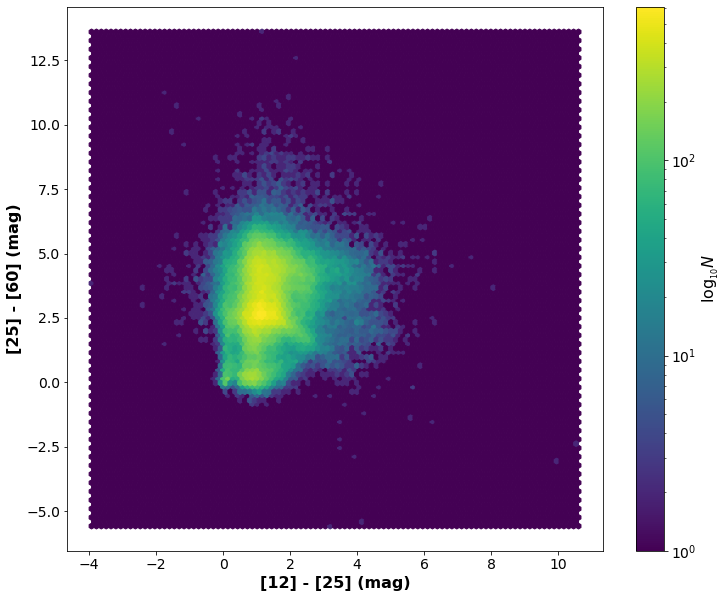

[30.8760088828, 7.26260108118, 1.11102363177, 0.386524359753]

In [ ]:
import subprocess
from astropy.io.votable import parse

filternames = ['IRAS/IRAS.12mu', 'IRAS/IRAS.25mu', 'IRAS/IRAS.60mu', 'IRAS/IRAS.100mu']
url = 'http://svo2.cab.inta-csic.es//theory/fps3/fps.php?ID='
fZP = [] # Vega zeropoint fluxes for the IRAS filters
for filtername in filternames:
  # Download the filter table from the SVO database
  _ = subprocess.call(['curl', '-o', 'temp.vot', url + filtername])
  # Parse the resulting VOTable and access the ZeroPoint PARAM in the header
  v = parse('temp.vot')
  fZP.append(v.get_field_by_id('ZeroPoint').value)
_ = subprocess.call(['rm', 'temp.vot'])

# Use these flux zeropoints to convert the IRAS PSC fluxes into magnitudes
fluxcols = ['psc12', 'psc25', 'psc60', 'psc100']
magcols = ['mag12', 'mag25', 'mag60', 'mag100']
for i in range(4):
  results[magcols[i]] = -2.512 * np.log10(results[fluxcols[i]] / np.repeat(fZP[i], len(results)))

# A Hess diagram (colour-colour diagram with density of points plotted) from the IRAS magnitudes
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
plt.hexbin(results['mag12'] - results['mag25'], results['mag25'] - results['mag60'], bins='log')
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 14)
cb.set_label(r'$\log_{_{10}}{N}$', size = 16)
plt.xlabel('[12] - [25] (mag)', fontdict = {'size': 16, 'weight': 'bold'})
plt.ylabel('[25] - [60] (mag)', fontdict = {'size': 16, 'weight': 'bold'})
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

fZP